# SUMMARY
---

## Dataset
- The dataset contains credit card activity of users for a 6-month period.
- The dataset was downloaded from kaggle.com

<br></br>
## Dimensionality Reduction
---
#### Methods investigated
- Principal Component Analysis (PCA)
- t-Distributed Stochastic Neighbor Embedding (t-SNE)
- Uniform Manifold Approximation and Projection (UMAP)

<br></br>
##### Of the 3 reduction methods, the reducing with UMAP results in the most separated datapoints, suggesting differences or uniqueness to them. Therefore, I will move forward with UMAP to visualize the data.
![dimensionality_reductoin_comparison](dimensionality_reduction_comparison.png)


<br></br>
## Choosing the Number of Clusters
---
#### Methods used
- Elbow Method
- Silhouette Coefficient

<br></br>
##### The Elbow Method plot below indicates that 3 or 4 clusters may be optimal. We should check with another method.
![elbow_method](elbow_method.png)

<br></br>
##### The silhouette coefficient plot blow shows that the `optimal number of clusters is 3`. This results in the highest silhouette coefficient.
![silhouette_coefficient](silhouette_coefficient.png)

## Clustering
---
#### Algorithms investigated
- $k$-means
- Hierarchical/Agglomerative clustering
- DBSCAN
- GMM

<br></br>
#### UMAPS
![clustering_plots_colored](clustering_plots_colored_umaps.png)
- Coloring the plots with the clusters shows various degrees of datapoint overlap.
- DBSCAN has not been useful in this analysis.
 - Searching `epsilon` and `min_samples` showed multiple combinations resulting in 3 clusters.
 - In actuality, these combinations produced at most 2 'real' clusters and a 'cluster' of outliers.
- Based on visual inspection alone, I would choose the agglomerative algorithm using Ward linkage and Euclidean affinity.
 - Clusters appear more separated, with less overlap than the other clustering algorithms.

<br></br>
#### TSNE
![clustering_plots_colored](clustering_plots_colored_tsne.png)
- Since the UMAPS plots were not as definitive as I'd hoped, let's look at the t-SNE visualizations.
- There are still various degrees of datapoint overlap between the algorithms.
- DBSCAN is just as unhelpful here.
- Based on visual inspection alone, I would again `select the agglomerative algorithm using Ward linkage and Euclidean affinity`.
 - The clusters are well concentrated to specific 'corners' of the figure and there is minimal overlap between datapoints relative to the other plots.

<br></br>
#### Silhouette coefficient
- To check visual inspection, I collected the silhouette coefficients for each algorithm.
- Surprisingly, the $k$-means algorithm produced the highest silhouette coefficient. Therefore, I would choose the `$k$-means algorithm as the best`.
 - 'kmeans': 0.2477
 - 'agg_comp_cos': 0.1090
 - 'agg_ward_euc': 0.1785
 - 'agg_avg_cos': 0.1618
 - 'dbscan_01eps_8minPts': -0.2509
 - 'dbscan_01eps_9minPts': -0.2512
 - 'dbscan_01eps_10minPts': -0.2512
 - 'gmm': 0.1151
![comparing algorithms](silhouette_coefficient_comparing_algos.png)

# SETUP
---

#### import packages

In [1]:
# data processing
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# clustering
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture

# dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# datasets
from sklearn.datasets import fetch_openml
from sklearn import datasets

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import time


#### set plot style

In [2]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to set plot style if no arguments provided
jtplot.style()

#### load dataset

In [3]:
df = pd.read_csv('CC_GENERAL.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
CUST_ID                             8950 non-null object
BALANCE                             8950 non-null float64
BALANCE_FREQUENCY                   8950 non-null float64
PURCHASES                           8950 non-null float64
ONEOFF_PURCHASES                    8950 non-null float64
INSTALLMENTS_PURCHASES              8950 non-null float64
CASH_ADVANCE                        8950 non-null float64
PURCHASES_FREQUENCY                 8950 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8950 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8950 non-null float64
CASH_ADVANCE_FREQUENCY              8950 non-null float64
CASH_ADVANCE_TRX                    8950 non-null int64
PURCHASES_TRX                       8950 non-null int64
CREDIT_LIMIT                        8949 non-null float64
PAYMENTS                            8950 non-null float64
MINIMUM_PAYMENTS            

In [5]:
df.shape

(8950, 18)

In [6]:
df.CUST_ID.nunique()

8950

In [7]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


#### define model

In [8]:
X = df.drop(['CUST_ID'], axis=1).dropna(axis=0)

# standardize data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12
5,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800.0,1400.057770,2407.246035,0.000000,12


In [9]:
X_std

array([[-0.74462486, -0.37004679, -0.42918384, ..., -0.30550763,
        -0.53772694,  0.35518066],
       [ 0.76415211,  0.06767893, -0.47320819, ...,  0.08768873,
         0.21238001,  0.35518066],
       [ 0.42660239,  0.50540465, -0.11641251, ..., -0.09990611,
        -0.53772694,  0.35518066],
       ...,
       [-0.75297728, -0.29709491, -0.40657175, ..., -0.32957217,
         0.30614422, -4.22180042],
       [-0.75772142, -0.29709491, -0.47320819, ..., -0.34081076,
         0.30614422, -4.22180042],
       [-0.58627829, -1.09958965,  0.03129519, ..., -0.32709767,
        -0.53772694, -4.22180042]])

# DIMENSIONALITY REDUCTION
---

#### pca

In [10]:
time_start = time.time()
print('PCA start...')
pca = PCA(n_components=2).fit_transform(X)
print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

PCA start...
PCA done! Time elapsed: 0.06734347343444824 seconds


#### t-sne

In [11]:
def run_tsne(X):
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(X)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    return tsne_results

tsne_results = run_tsne(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8636 samples in 0.049s...
[t-SNE] Computed neighbors for 8636 samples in 2.393s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8636
[t-SNE] Computed conditional probabilities for sample 2000 / 8636
[t-SNE] Computed conditional probabilities for sample 3000 / 8636
[t-SNE] Computed conditional probabilities for sample 4000 / 8636
[t-SNE] Computed conditional probabilities for sample 5000 / 8636
[t-SNE] Computed conditional probabilities for sample 6000 / 8636
[t-SNE] Computed conditional probabilities for sample 7000 / 8636
[t-SNE] Computed conditional probabilities for sample 8000 / 8636
[t-SNE] Computed conditional probabilities for sample 8636 / 8636
[t-SNE] Mean sigma: 0.468818
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.496864
[t-SNE] KL divergence after 300 iterations: 2.479820
t-SNE done! Time elapsed: 19.420907258987427 seconds


#### umap

In [12]:
def run_umap(X):
    time_start = time.time()
    print('UMAP start...')
    umap_results = umap.UMAP(n_neighbors=50, min_dist=0.1, metric='correlation').fit_transform(X)
    print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))
    return umap_results
    
umap_results = run_umap(X_std)

UMAP start...
UMAP done! Time elapsed: 36.282254219055176 seconds


# VISUALIZATION
---

#### define plotting functions

In [13]:
'''
    2D Plotting Function
        reduced_results: dimensionality-reduced data
        y: target classes/clusters for coloring
'''
def plot_2D(reduced_results, y=None):
      
    time_start = time.time()
    print('Plotting start...')
    
    plt.figure(figsize=(8,4))
    colours = ["r","g","y","m","w","b","c","limegreen"]
    #colours = ['tab:orange','tab:pink','tab:cyan']
    
    if y is not None:
        #for i in range(reduced_results.shape[0]):
            #plt.text(reduced_results[i, 0], reduced_results[i, 1], str(y[i]), color=colours[int(y[i])], fontdict={'weight': 'bold', 'size': 50})
        
        df_tmp = pd.concat([pd.DataFrame(reduced_results),pd.DataFrame(y)], axis=1)
        df_tmp.columns = ['x','y','cluster']
        
        for i in df_tmp.cluster.unique():
            plt.scatter(df_tmp[df_tmp.cluster == i].x, df_tmp[df_tmp.cluster == i].y, color = colours[i])
    else:        
        plt.scatter(reduced_results[:, 0], reduced_results[:, 1])#, marker='.',s=5.0)

    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    print('Plotting done! Time elapsed: {} seconds'.format(time.time()-time_start))
    #plt.show()

#### visualize data (no classes)

Plotting start...
Plotting done! Time elapsed: 0.032234907150268555 seconds
Plotting start...
Plotting done! Time elapsed: 0.023422956466674805 seconds
Plotting start...
Plotting done! Time elapsed: 0.024399995803833008 seconds


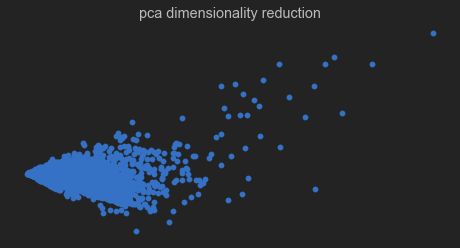

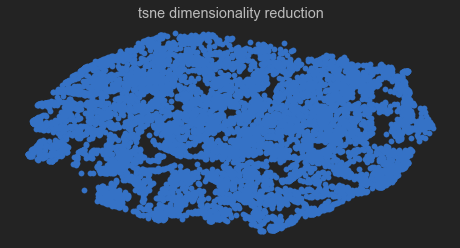

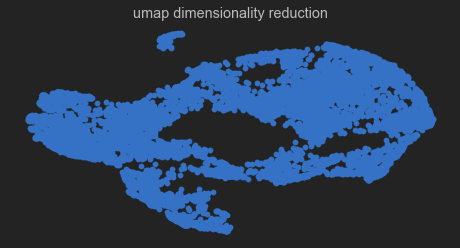

In [14]:
plot_2D(pca)
plt.title('pca dimensionality reduction')
plot_2D(tsne_results)
plt.title('tsne dimensionality reduction')
plot_2D(umap_results)
plt.title('umap dimensionality reduction')
plt.show()

# CLUSTERING
---

## determine best number of clusters

#### elbow method

- The elbow method is designed to help determine the appropriate number of clusters to use for unsupervised learning analysis.
- The goal with the Elbow Method is to plot the inertia, which is the within-cluster-sum-of-squares against the number of clusters.
- The appropriate number of clusters is the cluster after which the rate of improvement declines, creating an elbow shape.

<br></br>
Example Elbow Method Plot (optimal k=3)
![example elbow method](elbow_method_example.png)

#### plotting inertia vs. cluster number

It is not clear where the elbow is in the chart above. Let's try another method to determine $k$.

#### silhouette coefficient

- The `silhouette coefficient` is a measure of how similar the datapoints within a cluster are to one another. 
- The score for each datapoint is calculated as follows:
$$\dfrac{b_i-a_i}{max(b_i,a_i)}$$
 - $a_i$: mean distance between a datapoint and all other points in its cluster
 - $b_i$: mean distance between a datapoint and all points in the _neighboring_ clusters.
- The score for each cluster is just the mean of the scores of all datapoints in the cluster.
- A high value indicates a cluster's datapoints are well-matched to one another and poorly matched to other clusters.

##### The silhouette coefficient plot indicates that 3 clusters is the optimal choice.

In [15]:
_K_ = 3

In [16]:
algorithm_scores ={}

## $k$-means
---

In [18]:
time_start = time.time()
print('k-means start...')
kmeans_cluster = KMeans(n_clusters=_K_, random_state=123).fit_predict(X_std)
print('k-means done! Time elapsed: {} seconds'.format(time.time()-time_start))

# calculate silhouette_coefficient
algorithm_scores['kmeans'] = metrics.silhouette_score(X_std, kmeans_cluster, metric='euclidean')

# add to dataframe
df = df.dropna(axis=0)
df['KMEANS_CLUSTER'] = kmeans_cluster
y = df.KMEANS_CLUSTER.values
df.shape

k-means start...
k-means done! Time elapsed: 0.26412296295166016 seconds


(8636, 19)

Plotting start...
Plotting done! Time elapsed: 0.04879879951477051 seconds


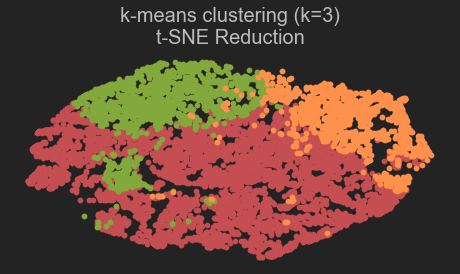

In [19]:
plot_2D(tsne_results, y)
plt.title(f'k-means clustering (k={_K_})\nt-SNE Reduction', fontsize=20)
plt.show()

Plotting start...
Plotting done! Time elapsed: 0.04880046844482422 seconds


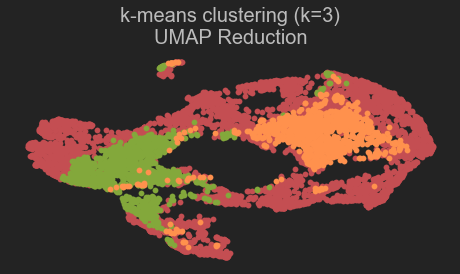

In [20]:
plot_2D(umap_results, y)
plt.title(f'k-means clustering (k={_K_})\nUMAP Reduction', fontsize=20)
plt.show()

## hierarchical clustering (agglomerative)
---

#### linkage method=complete, affinity/similarity metric=cosine

In [21]:
time_start = time.time()
print('agglomerative start...')
agg_cluster = AgglomerativeClustering(linkage='complete', affinity='cosine', n_clusters=_K_).fit_predict(X_std)
print('agglomerative done! Time elapsed: {} seconds'.format(time.time()-time_start))

# calculate silhouette_coefficient
algorithm_scores['agg_comp_cos'] = metrics.silhouette_score(X_std, agg_cluster, metric='euclidean')

# add to dataframe
df = df.dropna(axis=0)
df['AGG_comp_cos'] = agg_cluster
y = df.AGG_comp_cos.values
df.shape

agglomerative start...
agglomerative done! Time elapsed: 4.620726823806763 seconds


(8636, 20)

Plotting start...
Plotting done! Time elapsed: 0.052702903747558594 seconds


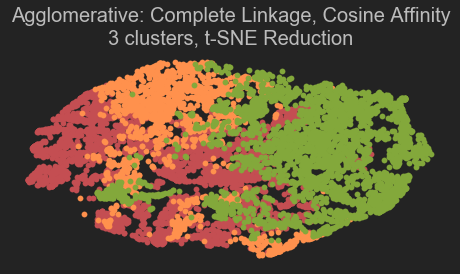

In [22]:
plot_2D(tsne_results, y)
plt.title(f'Agglomerative: Complete Linkage, Cosine Affinity\n{_K_} clusters, t-SNE Reduction', fontsize=20)
plt.show()

Plotting start...
Plotting done! Time elapsed: 0.049774885177612305 seconds


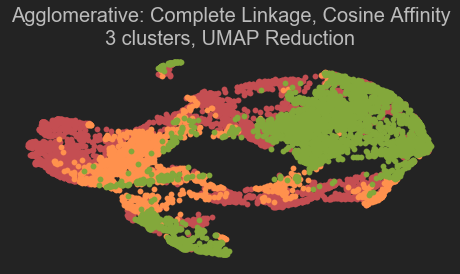

In [23]:
plot_2D(umap_results, y)
plt.title(f'Agglomerative: Complete Linkage, Cosine Affinity\n{_K_} clusters, UMAP Reduction', fontsize=20)
plt.show()

#### linkage method=ward, affinity/similarity metric=euclidean

In [24]:
time_start = time.time()
print('agglomerative start...')
agg_cluster = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=_K_).fit_predict(X_std)
print('agglomerative done! Time elapsed: {} seconds'.format(time.time()-time_start))

# calculate silhouette_coefficient
algorithm_scores['agg_ward_euc'] = metrics.silhouette_score(X_std, agg_cluster, metric='euclidean')

# add to dataframe
df = df.dropna(axis=0)
df['AGG_ward_euc'] = agg_cluster
y = df.AGG_ward_euc.values
df.shape

agglomerative start...
agglomerative done! Time elapsed: 4.05728816986084 seconds


(8636, 21)

Plotting start...
Plotting done! Time elapsed: 0.053680419921875 seconds


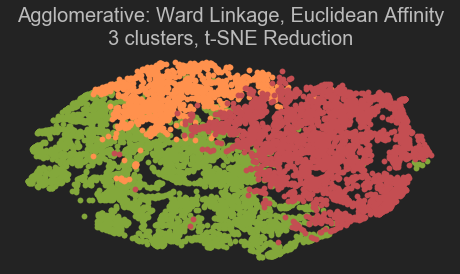

In [25]:
plot_2D(tsne_results, y)
plt.title(f'Agglomerative: Ward Linkage, Euclidean Affinity\n{_K_} clusters, t-SNE Reduction', fontsize=20)
plt.show()

Plotting start...
Plotting done! Time elapsed: 0.04977583885192871 seconds


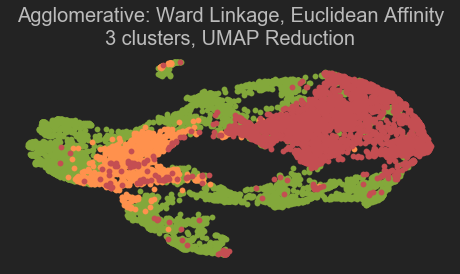

In [26]:
plot_2D(umap_results, y)
plt.title(f'Agglomerative: Ward Linkage, Euclidean Affinity\n{_K_} clusters, UMAP Reduction', fontsize=20)
plt.show()

#### linkage method=average, affinity/similarity metric=cosine

In [27]:
time_start = time.time()
print('agglomerative start...')
agg_cluster = AgglomerativeClustering(linkage='average', affinity='cosine', n_clusters=_K_).fit_predict(X_std)
print('agglomerative done! Time elapsed: {} seconds'.format(time.time()-time_start))

# calculate silhouette_coefficient
algorithm_scores['agg_avg_cos'] = metrics.silhouette_score(X_std, agg_cluster, metric='euclidean')

# add to dataframe
df = df.dropna(axis=0)
df['AGG_avg_cos'] = agg_cluster
y = df.AGG_avg_cos.values
df.shape

agglomerative start...
agglomerative done! Time elapsed: 3.7203853130340576 seconds


(8636, 22)

Plotting start...
Plotting done! Time elapsed: 0.05075263977050781 seconds


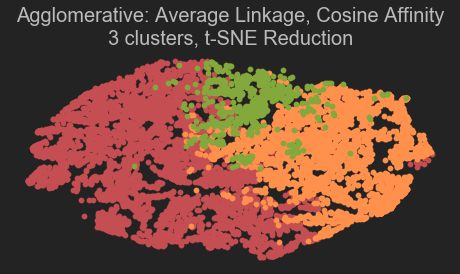

In [28]:
plot_2D(tsne_results, y)
plt.title(f'Agglomerative: Average Linkage, Cosine Affinity\n{_K_} clusters, t-SNE Reduction', fontsize=20)
plt.show()

Plotting start...
Plotting done! Time elapsed: 0.05173087120056152 seconds


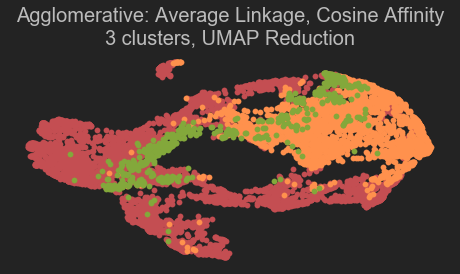

In [29]:
plot_2D(umap_results, y)
plt.title(f'Agglomerative: Average Linkage, Cosine Affinity\n{_K_} clusters, UMAP Reduction', fontsize=20)
plt.show()

## DBSCAN
---

#### search epsilon

#### search min_samples

#### epsilon=0.1, minPts=8

In [30]:
time_start = time.time()
print('dbscan start...')
dbscan_cluster = DBSCAN(eps=0.1, min_samples=8).fit_predict(X_std)
print('dbscan done! Time elapsed: {} seconds'.format(time.time()-time_start))

# calculate silhouette_coefficient
algorithm_scores['dbscan_01eps_8minPts'] = metrics.silhouette_score(X_std, dbscan_cluster, metric='euclidean')

# add to dataframe
df = df.dropna(axis=0)
df['DBSCAN'] = dbscan_cluster
y = df.DBSCAN.values
df.shape

dbscan start...
dbscan done! Time elapsed: 0.5334019660949707 seconds


(8636, 23)

Plotting start...
Plotting done! Time elapsed: 0.07319831848144531 seconds


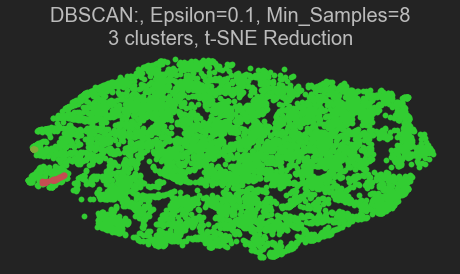

In [31]:
plot_2D(tsne_results, y)
plt.title(f'DBSCAN:, Epsilon=0.1, Min_Samples=8\n{_K_} clusters, t-SNE Reduction', fontsize=20)
plt.show()

Plotting start...
Plotting done! Time elapsed: 0.05376267433166504 seconds


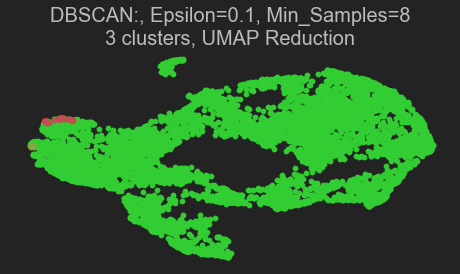

In [32]:
plot_2D(umap_results, y)
plt.title(f'DBSCAN:, Epsilon=0.1, Min_Samples=8\n{_K_} clusters, UMAP Reduction', fontsize=20)
plt.show()

#### epsilon=0.1, minPts=9

In [33]:
time_start = time.time()
print('dbscan start...')
dbscan_cluster = DBSCAN(eps=0.1, min_samples=9).fit_predict(X_std)
print('dbscan done! Time elapsed: {} seconds'.format(time.time()-time_start))

# calculate silhouette_coefficient
algorithm_scores['dbscan_01eps_9minPts'] = metrics.silhouette_score(X_std, dbscan_cluster, metric='euclidean')

# add to dataframe
df = df.dropna(axis=0)
df['DBSCAN'] = dbscan_cluster
y = df.DBSCAN.values
df.shape

dbscan start...
dbscan done! Time elapsed: 0.502638578414917 seconds


(8636, 23)

Plotting start...
Plotting done! Time elapsed: 0.0741739273071289 seconds


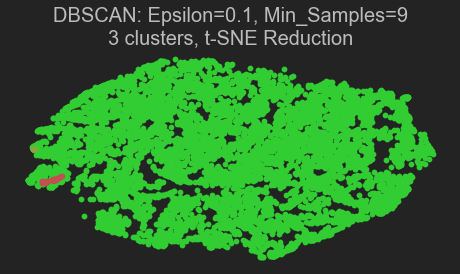

In [34]:
plot_2D(tsne_results, y)
plt.title(f'DBSCAN: Epsilon=0.1, Min_Samples=9\n{_K_} clusters, t-SNE Reduction', fontsize=20)
plt.show()

Plotting start...
Plotting done! Time elapsed: 0.052703142166137695 seconds


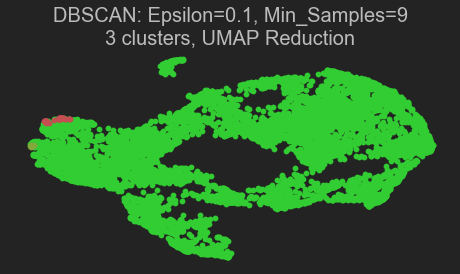

In [35]:
plot_2D(umap_results, y)
plt.title(f'DBSCAN: Epsilon=0.1, Min_Samples=9\n{_K_} clusters, UMAP Reduction', fontsize=20)
plt.show()

#### epsilon=0.1, minPts=10

In [36]:
time_start = time.time()
print('dbscan start...')
dbscan_cluster = DBSCAN(eps=0.1, min_samples=10).fit_predict(X_std)
print('dbscan done! Time elapsed: {} seconds'.format(time.time()-time_start))

# calculate silhouette_coefficient
algorithm_scores['dbscan_01eps_10minPts'] = metrics.silhouette_score(X_std, dbscan_cluster, metric='euclidean')

# add to dataframe
df = df.dropna(axis=0)
df['DBSCAN'] = dbscan_cluster
y = df.DBSCAN.values
df.shape

dbscan start...
dbscan done! Time elapsed: 0.5129082202911377 seconds


(8636, 23)

Plotting start...
Plotting done! Time elapsed: 0.07417774200439453 seconds


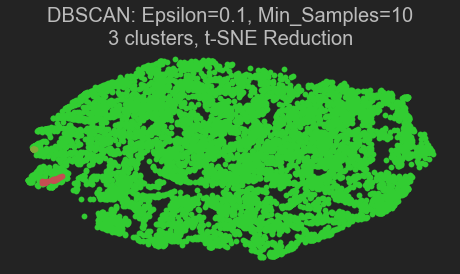

In [37]:
plot_2D(tsne_results, y)
plt.title(f'DBSCAN: Epsilon=0.1, Min_Samples=10\n{_K_} clusters, t-SNE Reduction', fontsize=20)
plt.show()

Plotting start...
Plotting done! Time elapsed: 0.04587435722351074 seconds


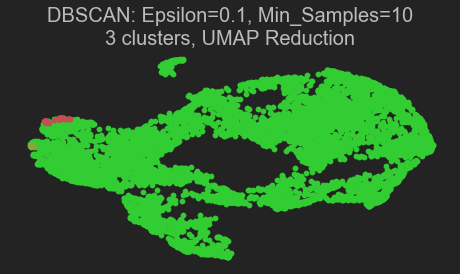

In [38]:
plot_2D(umap_results, y)
plt.title(f'DBSCAN: Epsilon=0.1, Min_Samples=10\n{_K_} clusters, UMAP Reduction', fontsize=20)
plt.show()

## GMM
---

In [39]:
time_start = time.time()
print('gmm start...')
gmm_cluster = GaussianMixture(n_components=_K_, random_state=123).fit_predict(X_std)
print('gmm done! Time elapsed: {} seconds'.format(time.time()-time_start))

# calculate silhouette_coefficient
algorithm_scores['gmm'] = metrics.silhouette_score(X_std, gmm_cluster, metric='euclidean')

# add to dataframe
df = df.dropna(axis=0)
df['GMM'] = gmm_cluster
y = df.GMM.values
df.shape

gmm start...
gmm done! Time elapsed: 0.7950422763824463 seconds


(8636, 24)

Plotting start...
Plotting done! Time elapsed: 0.09369540214538574 seconds


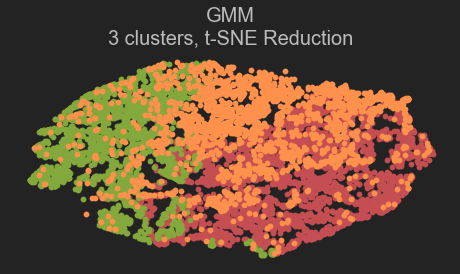

In [40]:
plot_2D(tsne_results, y)
plt.title(f'GMM\n{_K_} clusters, t-SNE Reduction', fontsize=20)
plt.show()

Plotting start...
Plotting done! Time elapsed: 0.05758357048034668 seconds


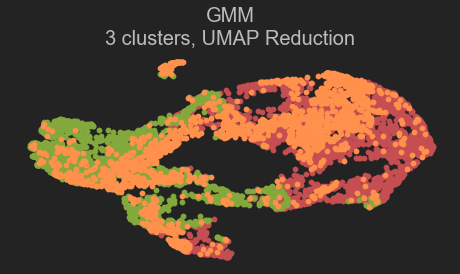

In [41]:
plot_2D(umap_results, y)
plt.title(f'GMM\n{_K_} clusters, UMAP Reduction', fontsize=20)
plt.show()

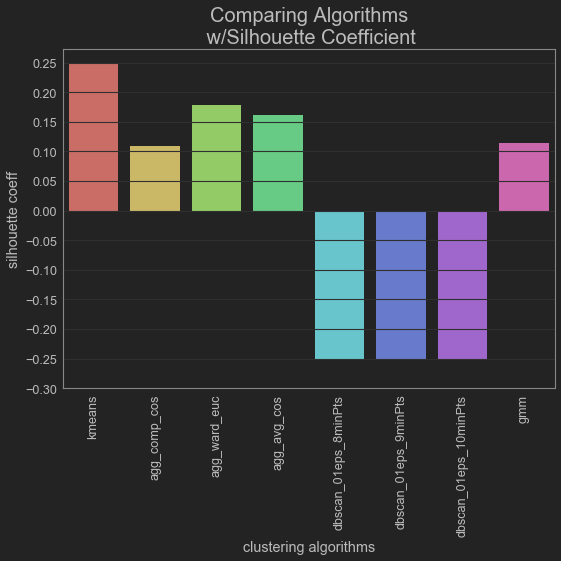

In [54]:
plt.rcParams['figure.figsize'] = (8,8)
sns.barplot(list(algorithm_scores.keys()), list(algorithm_scores.values()), palette='hls')
plt.xlabel('clustering algorithms')
plt.ylabel('silhouette coeff')
plt.xticks(rotation=90)
plt.yticks(np.arange(-0.3,0.3,0.05))
plt.title('Comparing Algorithms\n w/Silhouette Coefficient', fontsize=20)
plt.tight_layout()
plt.show()

In [55]:
algorithm_scores

{'kmeans': 0.24765773980405925,
 'agg_comp_cos': 0.10897007633760061,
 'agg_ward_euc': 0.17845266791386857,
 'agg_avg_cos': 0.1617553473104637,
 'dbscan_01eps_8minPts': -0.25090328181425725,
 'dbscan_01eps_9minPts': -0.25124562443919085,
 'dbscan_01eps_10minPts': -0.25124562443919085,
 'gmm': 0.11512267967773161}